In [1]:
from my_commonfunctions import *
from skimage.morphology import skeletonize, thin

In [2]:
def draw_hough_lines(lines, shape, line_thickness):
    lines_img = np.zeros(shape, dtype=np.uint8)
    for l in lines:
        #print(l)
        x1 = l[0][0]
        y1 = l[0][1]
        x2 = l[1][0]
        y2 = l[1][1]
        #print(x1, y1, x2, y2)
        cv2.line(lines_img, (x1,y1), (x2,y2), (255,255,255), line_thickness)

    return lines_img

29 3
(351, 217)




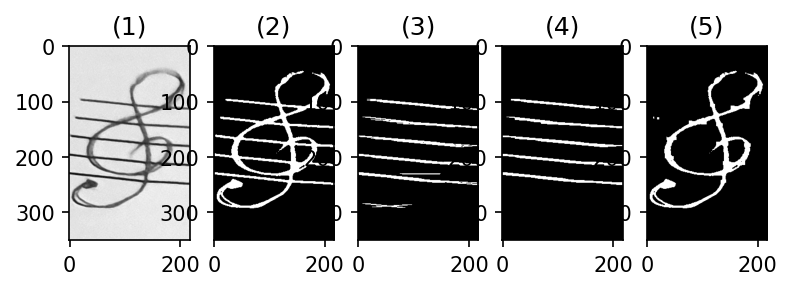

In [4]:
DEG_TO_RAD = np.pi/180

shubra1 = my_imread_gray('shubra1/13 6.jpg')
width = shubra1.shape[1]

# Otsu's thresholding
ret, shubra1_thresh = cv2.threshold(shubra1, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

distance_between_staves, staff_thickness = get_distance_between_staves_and_staff_thickness(shubra1_thresh)
print(distance_between_staves, staff_thickness)

shubra1_thresh = ~shubra1_thresh

line_length = int(width/4)
lines = probabilistic_hough_line(shubra1_thresh, threshold=10, line_length=line_length, line_gap=3, theta=np.arange(80*DEG_TO_RAD, 100*DEG_TO_RAD, 1*DEG_TO_RAD), seed=0)


lines_img_before_filteration = draw_hough_lines(lines, shubra1_thresh.shape, 1)
print(lines_img_before_filteration.shape)
lines_img_before_filteration = cv2.dilate(lines_img_before_filteration, np.ones((1, 11)))

lines_img = np.copy(lines_img_before_filteration)
image, contours, hierarchy = cv2.findContours(lines_img_before_filteration.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contours_bounding_rectangles = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    #print(x, y, w, h)
    contours_bounding_rectangles.append([c, [x, y, w, h]])

print()
print()

contours_bounding_rectangles_sorted = sorted(contours_bounding_rectangles, key = lambda x: x[1][2], reverse=True) # sort by width
contours_widest_5 = []
j = 5 if len(contours_bounding_rectangles_sorted) >= 5 else len(contours_bounding_rectangles_sorted)
for i in range(j):
    contours_widest_5.append(contours_bounding_rectangles_sorted[i][0])
    
lines_img = np.zeros(shubra1_thresh.shape, dtype=np.uint8)
lines_img = rgb2gray(cv2.drawContours(gray2rgb(lines_img), contours_widest_5, -1, (255,255,255), 1))
k = 3
lines_img = my_close(lines_img, np.ones((k*staff_thickness, k*staff_thickness)))
lines_img_flattened = (lines_img > 0.5).T.flatten()




shubra1_thresh_flattened = (shubra1_thresh).T.flatten()
#print(shubra1_thresh_flattened)
image, contours, hierarchy = cv2.findContours((shubra1_thresh_flattened).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# print(contours)

for c in contours:
    if c.shape == (2, 1, 2):
        p1 = c[1][0][1]
        p0 = c[0][0][1]
        m = 1.55
        if p1 - p0 <= staff_thickness*m:
            #print(c)
            staff_pixel_percentage = lines_img_flattened[p0:p1+1].sum() / len(lines_img_flattened[p0:p1+1])
            if staff_pixel_percentage > 0.35:
                shubra1_thresh_flattened[p0:p1+1] = 0
    elif c.shape == (1, 1, 2):
        #print(c)
        p0 = c[0][0][1]
        staff_pixel_percentage = lines_img_flattened[p0:p0+1].sum() / len(lines_img_flattened[p0:p0+1])
        if staff_pixel_percentage > 0.35:
            shubra1_thresh_flattened[p0:p0+1] = 0


staff_lines_removed = shubra1_thresh_flattened.reshape(shubra1_thresh.T.shape).T

#print(shubra1_thresh)
'''cv2.imwrite('lines_img.png', (lines_img*255).astype(np.uint8))
cv2.imwrite('shubra1_thresh.png', (((shubra1_thresh) > 128)*255).astype(np.uint8))'''


my_show_images([shubra1, shubra1_thresh, lines_img_before_filteration, lines_img, staff_lines_removed], dpi=150, row_max=5)

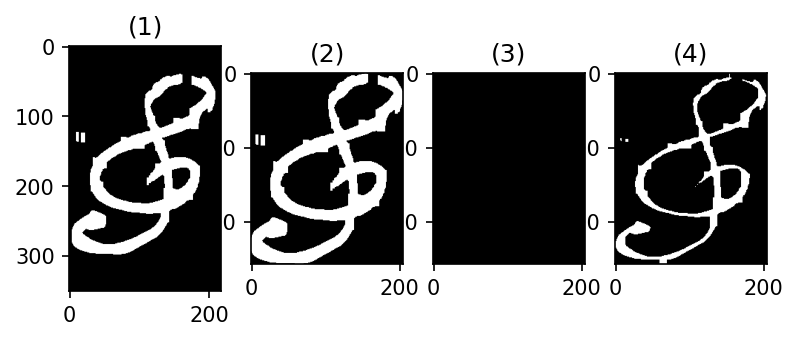

In [5]:
#thresh = cv2.adaptiveThreshold(255-staff_lines_removed, 256, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 1)
thresh = cv2.dilate(np.ascontiguousarray(staff_lines_removed), np.ones((11, 3)))
#print(staff_lines_removed.shape)

image, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
contours_drawn = gray2rgb(np.copy(thresh))
#ellipse = cv2.fitEllipse(contours[1])
#contours_drawn = cv2.ellipse(contours_drawn, ellipse, (0,255,0), 2)
max_area_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(max_area_contour)
zoomed_in = np.copy(thresh[y:y+h, x:x+w])


line_length = int(width*3/5)
lines = probabilistic_hough_line(zoomed_in, threshold=10, line_length=line_length, line_gap=3, theta=np.arange(80*DEG_TO_RAD, 100*DEG_TO_RAD, 1*DEG_TO_RAD), seed=0)


lines_drawn = my_close(draw_hough_lines(lines, zoomed_in.shape, 4), np.ones((5, 5)))
lines_drawn = cv2.erode(cv2.dilate(lines_drawn, np.ones((1, 45))), np.ones((9, 1)))

beam_partially_removed = cv2.erode((255-lines_drawn)/255 * zoomed_in, np.ones((11, 3)))

my_show_images([thresh, zoomed_in, lines_drawn, beam_partially_removed], dpi=150, row_max=4)